<a href="https://colab.research.google.com/github/rsuwa/self-driving-mini-car/blob/main/learn_steer_throttle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pwd

/content


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import glob
import PIL.Image
import os
import numpy as np

## スロットル値が0に近い画像を削除

In [4]:
import os

# フォルダのパスを設定
folder_path = "/content/drive/MyDrive/train_data_B" # 例: "/path/to/your/folder"
threshold = 0.0005  # スロットル値がこの値未満のファイルを削除

# フォルダ内のすべてのファイルをループ
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg"):  # .jpgファイルのみを対象
        # スロットル値を取得
        throttle_str = filename.split("_")[1]
        try:
            throttle = float(throttle_str)

            # スロットル値が指定された閾値未満かをチェック
            if abs(throttle) < threshold:
                file_path = os.path.join(folder_path, filename)
                os.remove(file_path)
                print(f"Removed {filename}")
        except ValueError:
            print(f"Could not convert {throttle_str} to float from filename {filename}")
            continue


In [5]:
def get_steering(path):
    """Gets the steering value from the image filename"""
    gets = path.split('_')
    return float(gets[0])

def get_speed(path):
    """Gets the speed value from the image filename"""
    gets = path.split('_')
    return float(gets[1])

class SSDataset(torch.utils.data.Dataset):

    def __init__(self, directory, random_hflips=False):
        self.directory = directory
        self.random_hflips = random_hflips
        self.image_paths = glob.glob(os.path.join(self.directory, '*.jpg'))
        self.color_jitter = transforms.ColorJitter(0.3, 0.3, 0.3, 0.3)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]

        image = PIL.Image.open(image_path)
        x = float(get_steering(os.path.basename(image_path)))
        y = float(get_speed(os.path.basename(image_path)))

        image = self.color_jitter(image)
        image = transforms.functional.resize(image, (224, 224))
        image = transforms.functional.to_tensor(image)
        image = image.numpy()[::-1].copy()
        image = torch.from_numpy(image)
        image = transforms.functional.normalize(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

        return image, torch.tensor([x, y]).float()

dataset = SSDataset('/content/drive/MyDrive/train_data_B', random_hflips=False)

In [6]:
test_percent = 0.1
num_test = int(test_percent * len(dataset))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset) - num_test, num_test])


In [7]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
model.fc = torch.nn.Linear(512, 2)
device = torch.device('cuda')
model = model.to(device)

# Frozen for modle layer1 to layer3
for l in model.layer1.parameters():
    l.requires_grad=False
for l in model.layer2.parameters():
    l.requires_grad=False
for l in model.layer3.parameters():
    l.requires_grad=False

In [10]:
EARLY_STOP = True


NUM_EPOCHS = 100
BEST_MODEL_PATH = 'best_steering_model_ResNet.pth'
best_loss = 1e9
optimizer = optim.Adam(model.parameters())

es_counter = 0
for epoch in range(NUM_EPOCHS):

    model.train()
    train_loss = 0.0
    for images, labels in iter(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = F.mse_loss(outputs, labels)
        loss.backward()
        train_loss += float(loss)
        optimizer.step()
    train_loss /= len(train_loader)

    model.eval()
    test_loss = 0.0
    for images, labels in iter(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = F.mse_loss(outputs, labels)
        test_loss += float(loss)
    test_loss /= len(test_loader)
    print('%d, %f, %f' % (epoch, train_loss, test_loss))
    if test_loss < best_loss:
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        best_loss = test_loss
        es_counter=0
    else:
        if es_counter == 7 and EARLY_STOP:
            print("Early Stopping EPOCH[{}], val_loss {:4f}".format(epoch, best_loss))
            break
        else:
            es_counter += 1


0, 0.053919, 0.045973
1, 0.023093, 0.020210
2, 0.019475, 0.016134
3, 0.017348, 0.017000
4, 0.015670, 0.015395
5, 0.014794, 0.013711
6, 0.014052, 0.012951
7, 0.014261, 0.014540
8, 0.012516, 0.015049
9, 0.012188, 0.016336
10, 0.011933, 0.012921
11, 0.010904, 0.014091
12, 0.011569, 0.014622
13, 0.010154, 0.012718
14, 0.009656, 0.015561
15, 0.010126, 0.018190
16, 0.009037, 0.012059
17, 0.007861, 0.011838
18, 0.008044, 0.011738
19, 0.007277, 0.013674
20, 0.007035, 0.013505
21, 0.006473, 0.010844
22, 0.006094, 0.011763
23, 0.005685, 0.011997
24, 0.005590, 0.013294
25, 0.005160, 0.010676
26, 0.004685, 0.010564
27, 0.004441, 0.009609
28, 0.004486, 0.013081
29, 0.004172, 0.009440
30, 0.003667, 0.012017
31, 0.003747, 0.009725
32, 0.004052, 0.011591
33, 0.003248, 0.010090
34, 0.003279, 0.013152
35, 0.002817, 0.009226
36, 0.003095, 0.009953
37, 0.002952, 0.009361
38, 0.002670, 0.010678
39, 0.002609, 0.010529
40, 0.002449, 0.009928
41, 0.002437, 0.009676
42, 0.002322, 0.009285
43, 0.002031, 0.00899

In [28]:
TEST_DATA_IMAGE = '/content/drive/MyDrive/train_data/0.601759_-0.180392_bc6d82ee-545c-11ee-94c2-02422eaea364.jpg'

model = torchvision.models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(512, 2)
model.load_state_dict(torch.load('best_steering_model_ResNet.pth'))
model = model.to(device)
model = model.eval()
image_path = TEST_DATA_IMAGE
image = PIL.Image.open(image_path)
image = transforms.functional.resize(image, (224, 224))
image = transforms.functional.to_tensor(image)
image = image.numpy()[::-1].copy()
image = torch.from_numpy(image)
image = transforms.functional.normalize(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]).to(device)
outputs = model(image[None, ...])
print(outputs)

tensor([[ 0.6666, -0.1288]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [30]:
image = PIL.Image.open(image_path)
image_orig_size = image.size

sample_image = transforms.functional.resize(image, (224, 224))


sample_image = transforms.functional.to_tensor(sample_image)
sample_image = sample_image.numpy()[::-1].copy()
sample_image = torch.from_numpy(sample_image)
sample_image = transforms.functional.normalize(sample_image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]).to(device)

In [31]:
# https://tech.jxpress.net/entry/2018/12/12/130057
# https://jacobgil.github.io/deeplearning/vehicle-steering-angle-visualizations
class GradCAM:
    def __init__(self, model, feature_layer):
        self.model = model
        self.feature_layer = feature_layer
        self.model.eval()
        self.feature_grad = None
        self.feature_map = None
        self.hooks = []

        # 最終層逆伝播時の勾配を記録する
        def save_feature_grad(module, in_grad, out_grad):
            self.feature_grad = out_grad[0]
        self.hooks.append(self.feature_layer.register_backward_hook(save_feature_grad))

        # 最終層の出力 Feature Map を記録する
        def save_feature_map(module, inp, outp):
            self.feature_map = outp[0]
        self.hooks.append(self.feature_layer.register_forward_hook(save_feature_map))

    def forward(self, x):
        return self.model(x)

    def backward_on_target(self,output):
        self.model.zero_grad()
        output.backward()

    def clear_hook(self):
        for hook in self.hooks:
            hook.remove()


In [32]:
model.eval()
grad_cam = GradCAM(model=model, feature_layer=list(model.layer4.modules())[-1])

In [35]:
model_output[0][0]

tensor(0.3486, device='cuda:0', grad_fn=<SelectBackward0>)

In [36]:
model_output = grad_cam.forward(sample_image[None, ...])
print(model_output)
#model_output.backward()
grad_cam.backward_on_target(model_output[0][0])

tensor([[ 0.6666, -0.1288]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [37]:
import numpy as np
# Get feature gradient
feature_grad = grad_cam.feature_grad.data.cpu().numpy()[0]
# Get weights from gradient
weights = np.mean(feature_grad, axis=(1, 2))  # Take averages for each gradient
# Get features outputs
feature_map = grad_cam.feature_map.data.cpu().numpy()
grad_cam.clear_hook()

In [38]:
# Get cam
cam = np.sum((weights * feature_map.T), axis=2).T
cam = np.maximum(cam, 0)  # apply ReLU to cam

In [39]:
print(cam)

[[0.01314074 0.01634879 0.01465587 0.0128957  0.00932877 0.00481241
  0.00458555]
 [0.00958135 0.01309943 0.01260349 0.01014123 0.00695602 0.00475174
  0.0049639 ]
 [0.01004464 0.0122647  0.01049472 0.00835964 0.00494751 0.00505226
  0.00300245]
 [0.00849608 0.00802605 0.00121416 0.         0.00120392 0.00170663
  0.00266183]
 [0.00435587 0.00447493 0.         0.         0.         0.
  0.        ]
 [0.03793951 0.         0.0139196  0.00285956 0.00626672 0.00768838
  0.00614648]
 [0.04569022 0.         0.01094904 0.0009543  0.00298812 0.00640426
  0.00605952]]


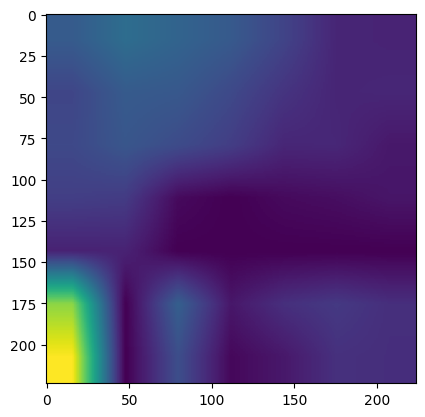

In [40]:
#(cam*10000).astype(np.uint8)
import cv2
import matplotlib.pyplot as plt
cam = cv2.resize(cam, (224,224))
cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
plt.imshow(cam)
plt.show()

In [41]:
activation_heatmap = np.expand_dims(cam, axis=0).transpose(1,2,0)
org_img = np.asarray(image.resize((224,224)))
img_with_heatmap = np.multiply(np.float32(activation_heatmap), np.float32(org_img))
img_with_heatmap = img_with_heatmap / np.max(img_with_heatmap)
org_img = cv2.resize(org_img, image_orig_size)

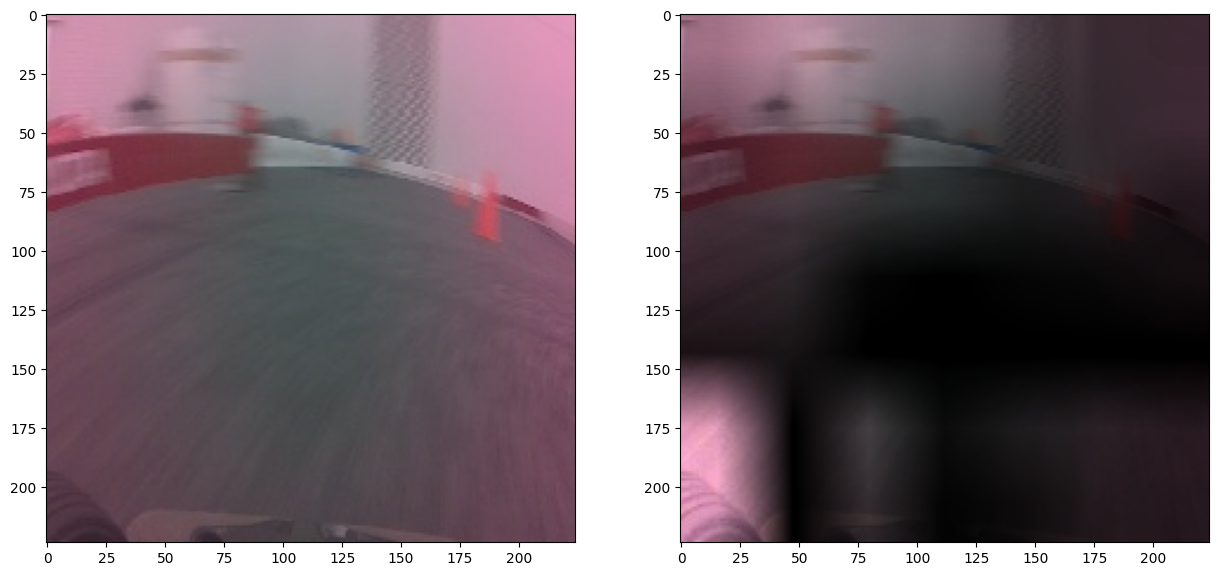

In [42]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(org_img)
plt.subplot(1,2,2)
plt.imshow(cv2.resize(np.uint8(255 * img_with_heatmap), image_orig_size))
plt.show()